# external z3 egraph

EggMT ( egraphs modulo theories)

In [32]:
from z3 import *
from dataclasses import dataclass
from functools import cache
from itertools import product
from collections import defaultdict

@cache
def z3_size(e):
    if is_app(e):
        return 1 + sum(z3_size(a) for a in e.children())
    return 1
def order(t1,t2):
    s1,s2 = z3_size(t1), z3_size(t2)
    if s1 > s2:
        return (t1, t2)
    elif s2 > s1:
        return (t2, t1)
    else:
        if t1.get_id() > t2.get_id(): # yeaaaa, I'm not sure this is ok.
            return (t1, t2)
        else:
            return (t2, t1)



@dataclass
class EGraph():
    R: list[tuple[ExprRef, ExprRef]]
    E: list[tuple[ExprRef, ExprRef]]
    T: dict[SortRef, set[ExprRef]]
    def __init__(self):
        self.solver = Solver()
        self.R = []
        self.E = []
        self.T = defaultdict(set) 
    def add_term(self, term):
        self.T[term.sort()].add(term)
        for t in term.children():
            self.add_term(t)
    def reduce_term(self, e):
        while True:
            e1 = z3.substitute(e, *self.R)
            if e.eq(e1): #fixpoint
                return e # simplify(e) reuse built in z3 simplify?
            e = e1
    def union(self, t1, t2):
        t1 = self.reduce_term(t1)
        t2 = self.reduce_term(t2)
        if not t1.eq(t2):
            self.solver.add(t1 == t2)
            #self.E.append((t1, t2))
            t1,t2 = order(t1, t2)
            self.R.append((t1, t2))
    def canon(self):
        self.T = defaultdict(set,{k : set(self.reduce_term(t) for t in Ts) for k,Ts in self.T.items()})
        # rule self reduction.
        """while self.E:
            t1,t2 = self.E.pop()
            t1 = self.reduce_term(t1)
            t2 = self.reduce_term(t2)
            if not t1.eq(t2):
            """
    def guard(self, C):
        self.solver.push()
        self.solver.add(Not(C))
        res = self.solver.check()
        self.solver.pop()
        if res == unsat:
            return True
        else:
            return False
    def rw(self, sorts, f, add=True):
        for t in product(*[self.T[sort] for sort in sorts]):
            lhs, rhs = f(*t)
            lhs = self.reduce_term(lhs) 
            if  lhs in self.T:
                if add:
                    # if add is false, we never increase T. It will terminate. This is yihong's thing?
                    self.add_term(rhs)
                self.union(lhs, rhs)
        #self.T
    def z3_simplify():
        # asserting built in z3 rules to the egraph
        # One of the perks of piggybacking on z3
        for t in self.T:
            t1 = z3.simplify(t)
            if not t1.eq(t):
                self.union(t, t1)
    def iter(self, *sorts):
        return product(*[self.T[sort] for sort in sorts])
    def rule(self, n, f):
        """
         f produces a lhs => rhs thing that 
        """
        for t in product(self.T, repeat=n):
            lhs, rhs = f(*t)
            self.solver.push()
            self.solver.add(Not(And(lhs)))
            res = self.solver.check()
            self.solver.pop()
            if res == unsat:
                self.solver.add(And(rhs))


x,y,z = Reals("x y z")
E = EGraph()
E.add_term(RealVal(1))
E.add_term(x + (y + z))
E.union(x, y)
E.union(x + x, z)
print(E)
E.canon()
E.rw([RealSort(), RealSort()], lambda x,y: (x + y, y + x))
print(E)
E.canon()
E


EGraph(R=[(y, x), (x + x, z)], E=[], T=defaultdict(<class 'set'>, {Real: {y, z, x, 1, y + z, x + y + z}}))
EGraph(R=[(y, x), (x + x, z)], E=[], T=defaultdict(<class 'set'>, {Real: {z, x, x + z, 1, x + x + z}}))


EGraph(R=[(y, x), (x + x, z)], E=[], T=defaultdict(<class 'set'>, {Real: {z, x, x + z, 1, x + x + z}}))

In [26]:
simplify(z + x + y + x) # ok so it doesn't order them. Huh

z + 2*x + y

Even if we weren't doing egraph stuff, this is kind of an interesting paradigm for quantifier instantion search.
Maybe I want to retain 


T : dict[SortRef, ExprRef]
def rw(self, f, *sorts):
    product(*[self.T[sort] for sort in sorts])

proofs

self.R


Miller Lambda
z3 <-> sympy




# Sequence Egraphs
There is a temptation that specializing egraphs for string like theories would be good.
Maybe it'd be easier to integerate associ or somm somehow.

Opens up string stroage like ideas.
Tries with eclasses
Regular string automata rather than tree automata


Paths are sequences.
Denali was sequences of instructions.


String rewriting is not 'ground". implicit variable is there. String rewriting aka egraphs + assoc is not decidable.
String rewriting at the tail only is ground.

String Knuth bendix could be one answer to a sequence egraph.
Or dual representation of cons, snoc. Then wqe can share both directions (?)


## KBMAG computationa group

What's the deal with the automata stuff

Twee sorting.
If we specialize commutiativyt, a very bad rule, to the individual guys, it becopmes sorting rules


This rewrite system will sort.


In [2]:
%%file /tmp/tweesort.p

fof(ax, axiom, ![X] : a(b(X)) = b(a(X))).
fof(ax, axiom, ![X] : a(c(X)) = c(a(X))).
fof(ax, axiom, ![X] : c(b(X)) = b(c(X))).

fof(goal,conjecture, true=false).


Overwriting /tmp/tweesort.p


In [3]:
!twee /tmp/tweesort.p

Here is the input problem:
  Axiom 1 (ax): a(b(X)) = b(a(X)).
  Axiom 2 (ax): a(c(X)) = c(a(X)).
  Axiom 3 (ax): c(b(X)) = b(c(X)).
  Goal 1 (goal): true = false.

1. b(a(X)) -> a(b(X))
2. c(a(X)) -> a(c(X))
3. c(b(X)) -> b(c(X))

Ran out of critical pairs. This means the conjecture is not true.
Here is the final rewrite system:
  b(a(X)) -> a(b(X))
  c(b(X)) -> b(c(X))
  c(a(X)) -> a(c(X))

RESULT: CounterSatisfiable (the conjecture is false).


# co-egraphs
What is the point of constructors?
1. injectivuity let's us know two things difenitely aren't equal
2. where does well foundedness come in? Detect unsoundness in our reasoning? Seems weak. Combined with context could be useful.
3. In pattern matching? We could restirct to "well founded matches"? a = Cons(b,xs)

PEGs need to describe streams
Streams are conductive things
We can use automata minimization to determine two objects are the same.


cofunctions
monotonicity requires obersvations go down.
partition ids

Go through old insane egglog notes.

mcrl2 + egraphs. I think mcrls has term rewriting. Jules jacobs  https://dl.acm.org/doi/abs/10.1145/3571245
https://mcrl2.org/web/index.html
Maybe use mcrl2 to prototype?

maude has a notion of transition system and object orientation does it do minimization



Supercompilation is egraph flavored.
Machine states.
Branching on unknowns, but then collecting back up?


Simple automata minimization

Could I do coegraph as a container?

```
data F = F F
f = F f
```

Landin's knot
```
f = []
f.append(f)
```

An egraph of a single node is impossible to create via adding ground terms.

In [27]:
f = []
f.append(f)
f

[[...]]

In [26]:
ex1 = {
  1 : (False, 2, 3),
  2 : (False, 4, 3),
  3 : (False, 5, 3),
  4 : (True, 5, 4),
  5 : (True, 4, 4)
}
def dfa_map(f,x):
  return {n : (term, f[a], f[b])  for n, (term, a, b) in x.items()}


from itertools import groupby
states = list(ex1.keys())
partmap = {i : states for i in range(1,6)}
for i in range(6):
    print(partmap)
    obs = dfa_map(partmap, ex1) # the observation map _is_ almost the partmap
    
    
    partmap = {}
    for obs1, equivs in groupby(states, lambda state: obs[state]):
        equivs = list(equivs)
        for id_ in equivs:
            partmap[id_] = equivs
    # not working
    #partmap = {state: list(partition) for (_, partition) in groupby(states, lambda state1: obs[state1]) for state in list(partition)}

# I don't _need_ partmap. Coukld have set of disjoint sets and you just scan it.


{1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5]}
{1: [1, 2, 3], 2: [1, 2, 3], 3: [1, 2, 3], 4: [4, 5], 5: [4, 5]}
{1: [1], 2: [2, 3], 3: [2, 3], 4: [4, 5], 5: [4, 5]}
{1: [1], 2: [2, 3], 3: [2, 3], 4: [4, 5], 5: [4, 5]}
{1: [1], 2: [2, 3], 3: [2, 3], 4: [4, 5], 5: [4, 5]}
{1: [1], 2: [2, 3], 3: [2, 3], 4: [4, 5], 5: [4, 5]}


In [1]:


ex1 = {
  1 : (False, 2, 3),
  2 : (False, 4, 3),
  3 : (False, 5, 3),
  4 : (True, 5, 4),
  5 : (True, 4, 4)
}

def dfa_map(f,x):
  return {n : (term, f[a], f[b])  for n, (term, a, b) in x.items()}

eqclass = {i : () for i in range(1,6)}
for _ in range(10):
  print(eqclass)
  eqclass = dfa_map(eqclass, ex1)
  #eqclass = {k : hash(v) for k,v in eqclass.items()} # not quite right. hash could collide. But you get the idea
  statelabel = { k : -i-1 for i,k in enumerate(set(eqclass.values()))} # negative just so I can see different between state and eqclass easier
  eqclass = {k : statelabel[v] for k,v in eqclass.items()} 

print(eqclass)

'''

Hmm.
What if I Z3-ified this process? A symbolic transition map. eqclass(c) = a.
Could use same justification tricks.

'''



{1: (), 2: (), 3: (), 4: (), 5: ()}
{1: -2, 2: -2, 3: -2, 4: -1, 5: -1}
{1: -1, 2: -2, 3: -2, 4: -3, 5: -3}
{1: -2, 2: -1, 3: -1, 4: -3, 5: -3}
{1: -2, 2: -1, 3: -1, 4: -3, 5: -3}
{1: -2, 2: -1, 3: -1, 4: -3, 5: -3}
{1: -2, 2: -1, 3: -1, 4: -3, 5: -3}
{1: -2, 2: -1, 3: -1, 4: -3, 5: -3}
{1: -2, 2: -1, 3: -1, 4: -3, 5: -3}
{1: -2, 2: -1, 3: -1, 4: -3, 5: -3}
{1: -2, 2: -1, 3: -1, 4: -3, 5: -3}


'\n\nHmm.\nWhat if I Z3-ified this process? A symbolic transition map. eqclass(c) = a.\nCould use same justification tricks.\n\n'

# Hyper Egraphs



# Nominal / Miller Ground Completion / Slotted

When is one term a subterm of another? For the full lambda calculus it isn't clear.

For completion egraphs I should maintain the rules _and_ the current term set (which is normalized / shrunk wrt the rules). We look into the set to match, but match  modulo the rules. Distinct purposes. In this way, I can drop a -> a rules.

The single loop egraoh 

f(e1) -> e1

So you can't get a general egraph out of term equations. We know this from PEG. PEG is trying to be coinductive and needs to tie a knot.



egraphs are like grammars? Multiple people said this. Tree automata are grammars ish.


refinement and egraphs. We have simplicity ordering and refinement ordering? They have to mesh? Term ordering becomes incomparable? Use unfailing ground completion?


assoc flattening. Regular knuth bendix ought to do this.
fof(axiom, add(add(X,Y), Z) = add(X,Y,Z)).
fof(axiom, add(Z, add(X,Y)) = add(Z, X,Y)).


Miller pattern lambda egraphs. Keep everything in eta expanded form

Miller pattern = we allow inverse beta genralization of lambdas, but only when they are applied to in scope variables.
Normal flat form
\x y z ... f(\x y. e1(x,y), \x z. e2(x, z)) -> \x y z. e3(x,y,z)

Pretty similar ish to nominal smushing
Allows for scope cpature
\x. foo(\y. bar(x)) == \x foo(\y (\z. bar(z))(x)) 
and in this sense, \z. bar(z) is a subterm of the original term.

If we keep everything expanded, we can use normal subterm algorithm?
So Maybe I could do z3 ground egraph using Z3 lambda.
Maybe we also want to allows commutativity in the binders.\x y f(x,y) ~~ \x y (\z w. f w z)(y,x)
Maybe also dropping binders. (\x y z. foo(x,y))(k,j,m) = (\x y foo(x,y))(k,j) 
Maybe dropping binders is a rewrite rule.
And commutativyt.
Then all we need is an ordering for closed lambda terms (?).

This is related to an old concept that we can kind of support multi arg lambdas

[a,b,c] foo() -> 



Ok, what about We only allow top level lambdas and any interesting inner lambda needs to be an indirection e1
Then we can use Var(0), Var(1)



In [11]:
from z3 import *
x,y,z = Reals("x y z")
assert not Lambda([x], x).eq(Lambda([y], y)) # fuck
assert x.eq(x)
assert Lambda([x], x).eq(Lambda([x], x))

substitute(Lambda([x], x), (Lambda([y], y), Lambda([z], RealVal(3))))

Lambda(x, x)

Nominal ground completion and slotted egraphs

https://link.springer.com/chapter/10.1007/978-3-642-31585-5_21
ominal Completion for Rewrite Systems with Binders

https://arxiv.org/pdf/0806.2517 cmputability pat hordering end of a auest

We can flatten to 3 layers


foo(bar(i,j), biz) becomes

biz = e1
bar(i,j) = e2(i,j)
foo(e2(i,j), e1) = e3(i,j)


nominal egraph

coalgerbaic egraphs for 

completion egraph is caonically serializable.
Takw ground rewrite system. Write rules down in order. Boom.
But if you flatten, non canonical. Huh.
Rules are just ordered tuples. Even easier than equations which are symmetrical. I suppose you could orientequations via a term order, but that's the point



Comparison of nominal terms. Nominal term orders.

1. stably under substituoion.
2. subterms are smaller than big term

Size first gets you 2

1. u > v -> t[u/x] > t[v/x] 
2. t[u] > u

stable under permutation
t > u -> Pt > Pu

so

i -> j two different atoms... Hmm. That's not a valid rule. Or rather it identifies all atoms. We can't orient it in a premutation invaraint way. Or is this saying that they are equal... ?
Consider like rotationally symmettric functions. Like radius or something. Also cross product like stuff.

f(i) -> j  Fine, it's smaller.
f(i,i) -> f(j,j) These are already "equal" ? Hmmm. Nooooo... It's confusing though 
f(i,j) -> f(i,i) I think I prefer. Reducing the number of different i is usually good. Or is having many independent i,j better?
f(i) > f(j) but this is permutation symmettric. I can't.. ok they're "equal" ish. I don't all a > a either.
f(i) -P> f(j) is analagous to a -> a.

"creating" new symbols is bad? Deleting them is better?

a > j  Hmmm. Could be. I suspect i want to eliminate vars though
j > a  
f(a) -> j ... hmm.
f(i,i) -> f(i,j)
f(i,i) -> f(j,k)

What about leftmost appearance as highest? A way of tiebreaking

can we have j -> f(j)  Well, not a rewriting order


The kmett union find. Hmm.

The multiset count of variables
size, multisetcount, symbol, recurse

multoisetcount does order f(i,i) vs f(i,j). a const function is like this. forall x y, f(i, x) = f(i, y) plausble axiom
We can never order f(i,j) f(k,l) (?) They are the "same" in some sense already.
f(i,j), f(i,k) also unorderable

lam(i, i) = lam(j,j) but foo(i,i) != foo(j,j) unless in scope of lam(i, foo(i,i)) = lam(j, foo(j,j))


In [ ]:
from dataclasses import dataclass
@dataclass 
class Term():
    head: Any
    args: list[Any]

@dataclass
class Atom():
    name:str


def nom_e1t1,t2):
    """nom_eq checks if two ground terms are equal modulo alpha renaming"""
    perm_ab = {}
    perm_ba = {}
    todo = [(t1,t2)]
    while todo:
        t1,t2 = todo.pop()
        match t1,t2:
            case Term(f,args), Term(f2,args2):
                if f != f2 or len(arg1s) != len(args2):
                    return None
                else:
                    todo.extend(zip(args1,args2))
            case Atom(a), Atom(b):
                if a in permab:
                    if perm_ab[a] != b:
                        return None
                elif b in perm_ba:
                    if prem_ba[b] != a:
                        return None
                else:
                    perm_ab[a] = b
                    perm_ba[b] = a
    return perm

# a knuth bendix like ordering for ground nominal terms.
# I'd probably want to tie break with # or nominal vars first
def nom_compare(t1,t2):
    perm = {}
    s1, s2 = size(t1), size(t2)
    if s1 < s2:
        return LE
    if s2 > s2:
        return GE
    else:


# red arrows can be labelled by a permutation




def flatten():




In [1]:
# miller ground matching. We allow a SINGLE beta0 matching.
# Yes. That is enough to carry arguments 

# Why can't we do full beta? Question is term t1 a subterm of t2 omdulo beta.
# (\x \y x )() 
# If we allowed arbitrary backwards evolution, we can lose all knids of terms. Any term is a subterm of another modulo beta in this sense.

# beta norm, eta long.

lam(x, lam(y, f x y)) == lam(x, lam(y, lam z(lam q))(x,y))


class App(): # multi app?
    f:
    x:
class Lam(): # multi lambda?
    x:
    body:
class Term():
    head:
    args:
class Var():
    name:str # de bruijn?

def miller_eq(t1,t2):

    #perm/subst?
    todo = [(t1,t2)]
    match t1, t2:
        perm? / subst?



def miller_compare(t1,t2):
    ?

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2776903280.py, line 3)

# Talk Notes

https://github.com/philzook58/egraphs2024-talk/blob/main/egraphs2024.pdf

- There was simplification.
- Brute Equational Search
 All automated theorem proving technology can be viewed in a similar application driven light as egraphs

Greedy:
- Missed optimizations
- Ordering of rules matters
- Hard to reason about
- Nontermination

Problems:
- Brute search is very explosive
- 

+ Egraphs
- Congruence Closure
- e-nodes and e-classes
- ![image.png](attachment:image.png)
- Applications
- Compiler/Simplification focus
- Theorem Proving
- Operational
- A notch more declarative than a greedy rewrite system
+ Philosophy
- What is it about egg? Pictures + Compiler. Not a conceptual high bar to entry.
- Non completeness
- Limited scope leads to highly refined, fast, implementation
- 


paramodulation is conditional


Convert equations into confluent terminating rewrite systems

- Basic Completion
    + Orient equations
    + Find critical pairs
    + reduce
- Don't back simplify anything (show example of this simple procedure here)
- Confusion: I barely care about confluence or termination. 
  + Completion is an effective equational theorem proving method.
  + a powerful and complete simplification methodology


(x * n) / n = x
(x * 2) = (x << 2)

orient 
(x * N) / N -> x
(x * 2) -> (x << 2)

critical pair (nontrivial overlap)
(x << 2) / 2 = x


Confluence  ~ a formulation of phase ordering problem
Completion solves the phase ordering problem

Conversely completion is an egraph extended with
- First class rewrite rules
- Universal variables

Advanced completion allows reducing redundant equations
A call to arms: Completion is useful compiler tech. Automated reasoning is compiler tech

show twee 
show twee proofs as an aside (a call to arms)

It is a saturation algorithm.


- Union finds can be seen as completed atomic rewrite systems
- Running the rewrite rules is calling `find`
- `union` is incrementally adding a new equation to R
- Union find is dynamic system that when you run produces canonical element
- Fixed point of f

Reverse the order here. Egrapoh should be left column

| Term Rewriting | Egraph |
|------|------------|
| Ground System     |   Egraph         |
| Ground Atomic | Union Find |
| Term Ordering  | Extraction Goal |
| Running | Extraction |
| R/L-simplify | Canonization |
| Run rules backwards | Egraph unrolling |
| Canonical term | Eclass |  


- If terms keep shrinking, they have to stop.
- [Ground KBO](https://www.philipzucker.com/ground_kbo/)




I've noted before it isn't obvious what goes into the box next to completion in the propositional case

Ground atomic superposition is a contextual union find.


? = completion
lambda prolog = ?
hilog = ?
contextual datalog = ?
hypothetical prolog = ?

- Combining Rewrite Rules and Ground Equations. Combination problems.
- When is it ok to combine ground rules and equations? Combination problems

Grobner is ground equations modulo rings. 

Lambda Term Orderings are not that well behaved

- Lambda Term Orderings
- SKI
- Lambda Free


Get example tree automata equation.
Give example of term families of given rewrite system

+ Term Orderings
- KBO ~ Smaller is better
- Union Find Tie Breaking




+ Equations
  
  paramodulation
- Superposition
- Egglog
- Functional Logic Programming


- Handbook of automated reasononig
- Term Rewriting and All That
- Automated Reasoning: An Introduction

- *If* successful "Master" equations

+ Bits and Bobbles

Slides from juptyer?  I can nbconvert


Animations?



E-matching against the ground egraph
  unification modulo egraphs or matching modulo egraphs


+ Resolution
- Resolution
- Ordered Resolution
- Datalog
- Prolog

Jasmin's cube

note: have box that like fills in? Left side is propositional, right is equational. 
not a \/ b === a -> b

 🧑‍🔬🔬🔍➡️🧪💥🔥🏃‍♂️🏃‍♀️🏃‍♂️🏃‍♀️😱🚒🚑🚓💦💧🌟


examples of phase ordering
examplers of non termination

    $$\{foo(bar(X)) \rightarrow biz(X);  bar(X) \rightarrow baz(X)\} \Rightarrow $$
    $$ [biz(X) = foo(baz(X))]$$

# Ground KBO

In [11]:
# ground KBO
from enum import Enum
from z3 import *
Order = Enum("Order", ["LT", "EQ", "NGE", "GT"])
def kbo(t, r):
    pass

def size(t:ExprRef):
    return 1 + sum(size(x) for x in t.children())
def ground_kbo(t1, t2):
    if t1.eq(t2): # optimization
        return Order.EQ
    s1 = size(t1)
    s2 = size(t2)
    if s1 < s2:
        return Order.LT
    elif s1 > s2:
        return Order.GT
    else:
        if t1.num_args() < t1.num_args():
            return Order.LT
        elif t2.num_args() > t2.num_args():
            return Order.GT
        n1, n2 = t1.decl().name(), t2.decl().name()
        if n1 < n2:
            return Order.LT
        elif n1 > n2:
            return Order.GT
        else:
            for x,y in zip(t1.children(), t2.children()):
                o = ground_kbo(x,y)
                if o != Order.EQ:
                    return o
            assert False, "unreachable"

In [6]:
# completion
"""
def reduce_atom(a,R): # find
    while True:
        for (l,r) in R:
            if a.eq(l):
                a = r
        else:
            break
"""
import z3
# https://microsoft.github.io/z3guide/programming/Example%20Programs/Formula%20Simplification/
def subterms(t):
    seen = {}
    def subterms_rec(t):
        if z3.is_app(t):
            for ch in t.children():
                if ch in seen:
                    continue
                seen[ch] = True
                yield ch
                yield from subterms_rec(ch)
    return { s for s in subterms_rec(t) }
def is_subterm(t1,t2):
    return t1 in subterms(t2)
def apply_rules(e, R):
    e1 = z3.substitute(e, *R)
    while not e.eq(e1):
        e = e1
        e1 = z3.substitute(e, *R)
    return e

def critical_pairs(R):
    for (l1,r1) in R:
        for (l2,r2) in R:
            if is_subterm(l1, l2):
                #r2 = z3.substitute(l2, (l1, r1))
                r1 = apply_rules(r1, R)
                r2 = apply_rules(r2, R)
                if not r1.eq(r2):
                    yield r1, r2

def complete(R):
    while True:
        Rnew = []
        for a,b in critical_pairs(R):
            match ground_kbo(a,b):
                case Order.GT:
                    a,b = a,b
                case Order.LT:
                    a,b = b,a
                case Order.EQ:
                    pass
            Rnew.append((a,b))
        if len(Rnew) == 0:
            break
        R.extend(Rnew)
    return R
        

def union(a,b,R):
    a = apply_rules(a, R) #find
    b = apply_rules(b, R) #find
    match ground_kbo(a,b):
        case Order.GT:
            a,b = a,b
        case Order.LT:
            a,b = b,a
        case Order.EQ:
            return R
    R.append((a,b))
    return R

a,b,c,d,e = z3.Ints("a b c d e")
R = []
union(b,a,R)
union(b,c,R)
union(a,c,R)
union(a,a,R)
union(b,d,R)
R
from IPython.display import display, Math
display(Math( r"\\".join(f"{a} \\rightarrow {b}" for a,b in R)))


<IPython.core.display.Math object>

## Z3 Ground KBO

http://www.cs.man.ac.uk/~regerg/ssa/ImpSaturation.pdf Implementation of Saturating Theorem Provers  scvhulz
https://www.youtube.com/watch?v=zja691VwfSA&ab_channel=JetBrainsResearch intro to superpsoition


In [ ]:
class Lit():
    lhs
    rhs

@dataclass
class Clause():
    neg:
    pos: list[]


# But is this factoring the most useful?
# simp table = lhs -> rhs
# simpe = lhs -> ctx -> rhs ? 



# fully z3 intragrated
# Implies(And(neg1,neg2), pos)

# Horn clause reallty.
# https://en.wikipedia.org/wiki/Horn-satisfiability
# but its horn sat modulo equality.






# Twee

mul(X,two) = shift(X, one)).
fof(cancel, axiom, ![X,N] : div(mul(X,N),N) = X

Twee sorting. 




Overwriting /tmp/context.p


In [13]:
!twee /tmp/context.p

Here is the input problem:
  Axiom 1 (cancel): e = f.
  Axiom 2 (cancel): c = d.
  Axiom 3 (ifeq_axiom): ifeq(X, X, Y, Z) = Y.
  Axiom 4 (shift): ifeq(a, b, b, c) = c.
  Goal 1 (goa): true = false.

1. f -> e
2. c -> d
3. ifeq(X, X, Y, Z) -> Y
4. ifeq(a, b, b, d) -> d

Ran out of critical pairs. This means the conjecture is not true.
Here is the final rewrite system:
  c -> d
  f -> e
  ifeq(X, X, Y, Z) -> Y
  ifeq(a, b, b, d) -> d

RESULT: CounterSatisfiable (the conjecture is false).


In [1]:
%%file /tmp/shift.p
fof(shift, axiom, ![X] : mul(X,two) = shift(X, one)).
fof(cancel, axiom, ![X,N] : div(mul(X,N),N) = X).
%fof(goal, conjecture, true = false).



Writing /tmp/shift.p


In [8]:
!/home/philip/.opam/5.1.1/bin/zipperposition /tmp/shift.p

# done 2 iterations in 0.011s
% Final clauses: 2
Clauses:
forall X0. [mul X0 two = shift X0 one*]/id:0/depth:0/penalty:1/red:false

forall X0 X1. [div (mul X0 X1) X1 = X0*]/id:1/depth:0/penalty:1/red:false
# SZS status Satisfiable for '/tmp/shift.p'


In [7]:
! eprover-ho /tmp/shift.p

# Initializing proof state
# Scanning for AC axioms
#
#cnf(i_0_2, plain, (div(mul(X1,X2),X2)=X1)).
#
#cnf(i_0_1, plain, (mul(X1,two)=shift(X1,one))).
#
#cnf(i_0_3, plain, (div(shift(X1,one),two)=X1)).

# No proof found!
# SZS status Satisfiable


In [10]:
!twee /tmp/shift.p

Here is the input problem:
  Axiom 1 (shift): mul(X, two) = shift(X, one).
  Axiom 2 (cancel): div(mul(X, Y), Y) = X.
  Goal 1 (goal): true = false.

1. mul(X, two) -> shift(X, one)
2. div(mul(X, Y), Y) -> X
3. div(shift(X, one), two) -> X

Ran out of critical pairs. This means the conjecture is not true.
Here is the final rewrite system:
  mul(X, two) -> shift(X, one)
  div(mul(X, Y), Y) -> X
  div(shift(X, one), two) -> X

RESULT: CounterSatisfiable (the conjecture is false).


# UF Vis

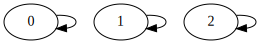

In [2]:
from graphviz import Digraph
class UF():
    def __init__(self):
        self.parent = []
    def find(self, x):
        while x != self.parent[x]:
           x = self.parent[x] 
        return x
    def makeset(self):
        n = len(self.parent)
        self.parent.append(n)
        return n
    def union(self, x, y):
        self.parent[self.find(x)] = self.find(y)
    def __repr__(self):
        return str(self.parent)
    def viz(self):
        dot = Digraph()
        for i, p in enumerate(self.parent):
            dot.edge(str(i), str(p))
        return dot
uf = UF()
zero = uf.makeset()
one = uf.makeset()
two = uf.makeset()

uf.viz()


In [ ]:
uf.union(zero, one)
uf.viz()

In [ ]:
from typing import Optional, Iterable, Dict
def match_(t : AstRef, pat : AstRef, vars : Iterable[ExprRef] = []) -> Optional[Dict[ExprRef,ExprRef]]:
    subst = {}
    todo = [(t,pat)]
    while todo:
        t,pat = todo.pop()
        if pat in vars or is_var(pat): # allow var as pattern?
            if pat in subst:
                if subst[pat].eq(t):
                    pass
                else:
                    return None
            else:
                subst[pat] = t
        elif isinstance(t, QuantifierRef) or isinstance(pat, QuantifierRef):
            raise NotImplementedError
        else:
            thead, targs = t.decl(), t.children()
            phead, pargs = pat.decl(), pat.children()
            if thead != phead or len(targs) != len(pargs): # check sorts here? The decl might check that
                return None
            todo.extend(zip(targs, pargs))
    return subst

E = DeclareSort("Expr")
foo = Function("foo", E, E, E)
bar = Function("bar", E, E)
a,b,c = Consts("a b c", E)
x,y,z = Consts("x y z", E)
vars = {x,y,z}

assert match_(foo(x, bar(y)), foo(a, bar(b)), vars) == None
assert match_(foo(a, bar(b)), foo(x, bar(y)), vars) == {x:a, y:b}
assert match_(foo(a, bar(b)), foo(a, bar(b)), vars) == {}
assert match_(foo(a, bar(b)), foo(x,x), vars) == None
assert match_(foo(a, bar(a)), foo(x,bar(x)), vars) == {x:a}
match_(foo(a, bar(a)), Lambda([x],foo(x,bar(x))).body()) == {Var(0, E):a}

In [ ]:
from z3 import *
a = BitVec("a", 32)

e = (a * 2) / 2
e1 = (a << 1) / 2

a * 2 == a << 1
(a * 2) / 2 == a


E = [
    (a * 2, a << 1),
    ((a * 2) / 2, a)
]
# what else might be a good example?

# a + b + c
# a + b + a + b

In [7]:
import graphviz
from z3 import *
a,b,c,d,e,f,g = Consts("a b c d e f g", IntSort())
R = [
(b,a),
(c,a),
(d,a),
(e,a),
(g,f)
]

dot.edge(node(l), node(r), style="dashed")

NameError: name 'dot' is not defined

## Term Graph Vis

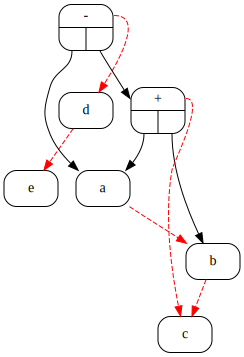

In [44]:
import graphviz
def node(e):
    #print(e, e.get_id())
    return str(e.get_id())

def graphviz_of_z3(e, dot):
    #label = "<head>" + e.decl().name() + "| {" + "|".join([ f"<p{n}>{n}" for n in range(e.num_args())]) + "}"
    if e.num_args() == 0:
        label = f'{{<head>{e.decl().name()}}}'
    else:
        label = f'{{<head>{e.decl().name()}|{{{"|".join([f"<p{n}>" for n in range(e.num_args())])}}}}}'
    #print(label)
    dot.node(node(e), label, shape="Mrecord") # id?
    for n,c in enumerate(e.children()):
        a,b = node(e) + ":p" + str(n) , node(c) + ":head"
        if (a,b) not in dot.added_edges:
            dot.added_edges.add((a,b))
            dot.edge(a,b)
        graphviz_of_z3(c, dot)

def show_rewrite(R):
    dot = graphviz.Digraph()
    dot.added_edges = set()
    for l,r in R:

        dot.edge(node(l) + ":head", node(r) + ":head", style="dashed", color="red")
        graphviz_of_z3(l,dot)
        graphviz_of_z3(r,dot)
    return dot
        
from z3 import *
a,b,c,d,e = Consts("a b c d e", IntSort())

show_rewrite([(a,b), (b,c), (d,e), (a  + b, c), (a-(a+b), d)])

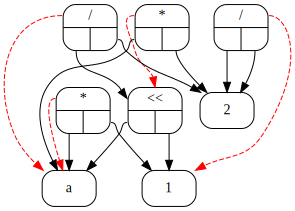

In [45]:
BV = DeclareSort("BV")
mul = Function("*", BV, BV, BV)
shift = Function("\<\<", BV, BV, BV)
div = Function("/", BV, BV, BV)
a,one,two= Consts("a 1 2", BV)
start = Const("start", BV)
R = [
  (mul(a, two) , shift(a, one)),
  (mul(a, one) , a),
  (div(two, two) , one),
  (div(shift(a, one), two) , a),
  #(start , a)
]
show_rewrite(R)

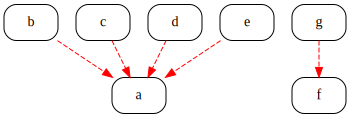

In [46]:
R = [
(b,a),
(c,a),
(d,a),
(e,a),
(g,f)
]
show_rewrite(R)